# Data download

Epidemiologic surveillance system of Mexico City:

https://datos.cdmx.gob.mx/dataset/base-covid-sinave

In [1]:
!wget -c "https://archivo.datos.cdmx.gob.mx/sisver/sisver_public.csv"

--2021-12-08 22:03:38--  https://archivo.datos.cdmx.gob.mx/sisver/sisver_public.csv
Resolving archivo.datos.cdmx.gob.mx (archivo.datos.cdmx.gob.mx)... 189.240.234.120
Connecting to archivo.datos.cdmx.gob.mx (archivo.datos.cdmx.gob.mx)|189.240.234.120|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



# Import Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

# Import Data

In [3]:
df = pd.read_csv("sisver_public.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (78,79) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.shape

(4540149, 92)

# Preprocessing

Lets create a subset only with positive or negative covid cases:

In [5]:
df = df[df['resdefin'].isin(['NEGATIVO','SARS-CoV-2'])] 

Lets now select the most interesting fields

In [6]:
columns = ['fechreg', 'sexo', 'tipacien', 'fecdef', 'intubado', 'digcline', 'edad', 'fiebre', 'tos', 'odinogia', 'disnea', 'irritabi', 'diarrea', 
           'dotoraci','calofrios', 'cefalea','mialgias', 'artral', 'ataedoge', 	'rinorrea', 	'polipnea', 	'vomito', 	'dolabdo', 	'conjun', 	'cianosis',
           'inisubis', 	'diabetes', 	'epoc', 	'asma', 	'inmusupr', 	'hiperten', 	'vih_sida', 	'otracon', 	'enfcardi', 	'obesidad', 	'insrencr',
           'tabaquis', 'resdefin']

In [7]:
labels_translation = {"sexo":"Sex", "tipacien":"TypeOfPatient","fecdef":"DefunctionDate",
                      "digcline":"Pneumonia", "edad":"Age", "fiebre":"Fever","tos":"Cough",
                      "odinogia":"Odynophagia", "disnea":"ShortnessOfBreath", "irritabi":"Irritability",
                      "diarrea":"Diarrhea", 'dotoraci':"ThoracicPain",'calofrios':"Chills", 
                      'cefalea':"Headache",'mialgias':"Myalgia", 'artral':"Arthralgia", 
                      'ataedoge':"PoorGeneralCondition", 'rinorrea':"Rhinorrhea", 	
                      'polipnea':"Polypnea", 	'vomito':"Vomit", 	'dolabdo':"AbdominalPain",
                      'conjun':"Conjunctivitis", 	'cianosis':"Cyanosis", 'inisubis':"SuddenSyndromStart",
                      'diabetes':"Diabetes", 	'epoc':"COPD", 	'asma':"Asthma", 	'inmusupr':"Immunosuppression",
                      'hiperten':"Hypertension", 	'vih_sida':"HIV/AIDS", 	'otracon':"OtherCommorbidity",
                      'enfcardi':"CardiovascularDisease", 	'obesidad':"Obesity", 'insrencr':"ChronicKidneyDisease",
                      'tabaquis':"Smoking", 'resdefin':"COVID-19"}

Lets create a subset with this fields:

In [8]:
dfmini = df.loc[:,columns]
print(dfmini.shape)
dfmini.head()

(4365249, 38)


,fechreg,sexo,tipacien,fecdef,intubado,digcline,edad,fiebre,tos,odinogia,disnea,irritabi,diarrea,dotoraci,calofrios,cefalea,mialgias,artral,ataedoge,rinorrea,polipnea,vomito,dolabdo,conjun,cianosis,inisubis,diabetes,epoc,asma,inmusupr,hiperten,vih_sida,otracon,enfcardi,obesidad,insrencr,tabaquis,resdefin
0,2021-03-18T00:00:00Z,MASCULINO,AMBULATORIO,NaN,NaN,NO,70,NO,SI,SI,SI,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NEGATIVO
1,2021-06-16T00:00:00Z,MASCULINO,AMBULATORIO,NaN,NaN,NO,29,NO,SI,NO,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NEGATIVO
2,2021-09-15T00:00:00Z,MASCULINO,AMBULATORIO,NaN,NaN,NO,34,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NEGATIVO
3,2021-09-04T00:00:00Z,MASCULINO,HOSPITALIZADO,NaN,NO,NO,20,NO,NO,NO,NO,NO,NO,NO,NO,NO,SI,SI,SI,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NEGATIVO
4,2021-03-22T00:00:00Z,MASCULINO,AMBULATORIO,NaN,NaN,NO,22,SI,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,SI,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NEGATIVO


Lets check for empty values:

In [9]:
nulls = (dfmini.isnull().sum()/len(dfmini)).sort_values(ascending=False)[:5]
print(nulls)

fecdef      0.986960
intubado    0.961596
digcline    0.000151
resdefin    0.000000
disnea      0.000000
dtype: float64


Lets fill the NaNs with default values

    fecdef (defunction date) -> if empty hasn't die

    intubado (intubated)  -> if empty wasn't intubated
    
    digcline (clinic diagnoses of Pneumonia)  -> if empty was not diagnosed


In [10]:
dfmini["fecdef"].fillna("NO", inplace=True)
dfmini["intubado"].fillna("NO", inplace=True)
dfmini["digcline"].fillna("NO", inplace=True)
# Lets change defunction dates to a binary indicator of whether the patient died or not
dfmini["fecdef"] = dfmini["fecdef"].map(lambda x: "SI" if x != "NO" else x)

Lets check again for null values

In [11]:
(dfmini.isnull().sum()/len(dfmini)).sort_values(ascending=False)[:5]

resdefin     0.0
odinogia     0.0
mialgias     0.0
cefalea      0.0
calofrios    0.0
dtype: float64

In [12]:
dfmini.diabetes.unique(), dfmini.shape

(array(['NO', 'SI', 'SE IGNORA'], dtype=object), (4365249, 38))

Lets remove unknown data:

In [13]:
to_check = ['fiebre', 'tos', 'odinogia', 'disnea', 'irritabi', 'diarrea', 'dotoraci',
            'calofrios', 'cefalea','mialgias', 'artral', 'ataedoge', 	'rinorrea', 	
            'polipnea', 	'vomito', 	'dolabdo', 	'conjun', 	'cianosis','inisubis', 	
            'diabetes', 	'epoc', 	'asma', 	'inmusupr', 	'hiperten', 	'vih_sida', 	
            'otracon', 	'enfcardi', 	'obesidad', 	'insrencr','tabaquis']

for col in to_check:
  dfmini = dfmini[dfmini[col] != 'SE IGNORA']

dfmini.shape

(4323774, 38)

In [14]:
dfmini.diabetes.unique(), dfmini.shape

(array(['NO', 'SI'], dtype=object), (4323774, 38))

Lets change the boolean word of "No" and "Sí" for 0s and 1s.

In [15]:
cat = {}
for col in dfmini:
  if col in ["fechreg", "edad"]: continue 
  map = {x:i for i,x in enumerate(dfmini[col].unique())}
  cat[col] = map
  dfmini[col] = dfmini[col].map(map)

dfmini.head()

,fechreg,sexo,tipacien,fecdef,intubado,digcline,edad,fiebre,tos,odinogia,disnea,irritabi,diarrea,dotoraci,calofrios,cefalea,mialgias,artral,ataedoge,rinorrea,polipnea,vomito,dolabdo,conjun,cianosis,inisubis,diabetes,epoc,asma,inmusupr,hiperten,vih_sida,otracon,enfcardi,obesidad,insrencr,tabaquis,resdefin
0,2021-03-18T00:00:00Z,0,0,0,0,0,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-06-16T00:00:00Z,0,0,0,0,0,29,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-09-15T00:00:00Z,0,0,0,0,0,34,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-09-04T00:00:00Z,0,1,0,0,0,20,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-03-22T00:00:00Z,0,0,0,0,0,22,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
dfmini = dfmini.sample(2000000, random_state=42) # two million registers

Lets make a dataset for symptoms and covid-19 diagnoses:

In [17]:
# Lets create a dataframe to try to detect covid given the symptoms
col_sin = ['sexo', 'edad', 'fiebre', 'tos', 'odinogia', 'disnea', 'irritabi', 'diarrea', 
           'dotoraci','calofrios', 'cefalea', 'mialgias', 'artral', 'ataedoge', 'rinorrea', 'polipnea',	'vomito', 'dolabdo', 'conjun', 'cianosis',
           'inisubis', 'resdefin'] #'tipacien', 'intubado', 'digcline', 

df_sin = dfmini.loc[:,col_sin]
df_sin.head(), df_sin.shape

(         sexo  edad  fiebre  tos  ...  conjun  cianosis  inisubis  resdefin
 4389833     1    29       0    1  ...       0         0         0         0
 2784403     1    32       0    0  ...       0         0         0         0
 491645      1    62       0    1  ...       0         0         0         0
 435542      1    63       0    1  ...       0         0         0         0
 3300225     1     6       1    1  ...       0         0         0         0
 
 [5 rows x 22 columns], (2000000, 22))

Lets make a dataframe for the comorbidities and defuntion outcome given a pacient is positive to covid-19.

In [18]:
# Lets create a dataframe for deaths given the comorbidities
col_com  = ['sexo', 'edad', 'diabetes',	'epoc', 'asma',	'inmusupr', 
            'hiperten', 'vih_sida', 'otracon', 'enfcardi', 'obesidad', 'insrencr',
            'tabaquis', 'resdefin', 'fecdef']

df_com = dfmini.loc[:,col_com]
df_com = df_com[df_com['resdefin']==1]
df_com.drop('resdefin', axis=1, inplace=True)
df_com.head(), df_com.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(         sexo  edad  diabetes  epoc  ...  obesidad  insrencr  tabaquis  fecdef
 2342707     1     3         0     0  ...         0         0         0       0
 2115266     0    27         0     0  ...         1         0         0       0
 3479490     1     7         0     0  ...         0         0         0       0
 2328255     0    58         0     0  ...         0         0         0       0
 2008950     0    22         0     0  ...         0         0         1       0
 
 [5 rows x 14 columns], (420723, 14))

Lets now make a dataframe to try to predict if a pacient will be hospitalized given his symptoms and comorbidities:

Tratamos de predecir si el paciente quedara hospitalizado a traves de sus sintomas y comorbilidades, observe que el hecho de que el paciente este intubado implica que esta hospitalizado, asi que creamos un nuevo dataframe borrando esta columnas, asi como las columnas, tippacien,fecdef,resdefin y tomamos la columna $y$ como la columna que nos dice si el paciente fue hospitalizado o no

In [19]:
# Lets create a dataframe for hospitalizations given symptoms and comorbidities
symptoms_and_com = ['sexo', 'digcline', 'edad', 'fiebre', 'tos', 'odinogia', 'disnea', 'irritabi', 'diarrea', 
           'dotoraci','calofrios', 'cefalea','mialgias', 'artral', 'ataedoge', 	'rinorrea', 	'polipnea', 	'vomito', 	'dolabdo', 	'conjun', 	'cianosis',
           'inisubis', 	'diabetes', 	'epoc', 	'asma', 	'inmusupr', 	'hiperten', 	'vih_sida', 	'otracon', 	'enfcardi', 	'obesidad', 	'insrencr',
           'tabaquis', 'resdefin', 'tipacien']

In [20]:
df_hosp = dfmini.loc[:,symptoms_and_com] # Symptoms and comorbidities
df_hosp = df_hosp[df_hosp.resdefin == 1]  # Given the patient has covid
df_hosp.drop('resdefin', axis=1, inplace=True)
df_hosp

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,sexo,digcline,edad,fiebre,tos,odinogia,disnea,irritabi,diarrea,dotoraci,calofrios,cefalea,mialgias,artral,ataedoge,rinorrea,polipnea,vomito,dolabdo,conjun,cianosis,inisubis,diabetes,epoc,asma,inmusupr,hiperten,vih_sida,otracon,enfcardi,obesidad,insrencr,tabaquis,tipacien
2342707,1,0,3,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2115266,0,0,27,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3479490,1,0,7,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2328255,0,0,58,1,1,1,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2008950,0,0,22,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257938,0,0,38,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2541214,0,0,34,0,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2790526,0,0,37,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2917793,1,0,31,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# ML algorithms

### Metrics

In [21]:
def get_f1_score(clf, X_test, y_test):
  y_pred = clf.predict(X_test)
  return f1_score(y_test, y_pred)

In [22]:
def get_precision_score(clf, X_test, y_test):
  y_pred = clf.predict(X_test)
  return precision_score(y_test, y_pred)

In [23]:
def get_sensibility(clf, X_test, y_test):
  y_pred = clf.predict(X_test)
  return recall_score(y_test, y_pred)

In [24]:
def plot_roc(y_score, y_test):
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
  plt.figure()
  lw = 2
  plt.plot(
      fpr,
      tpr,
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % auc(fpr, tpr),
  )
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic curve")
  plt.legend(loc="lower right")
  plt.show()

## Algorithm Functions

#### Decisión tree

In [25]:
def tree_classifier(X_train, y_train, X_test, y_test, max_depth=100, min_samples_leaf=2):

    dt = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    acc = dt.fit(X_train, y_train).score(X_test, y_test)
    
    return dt, acc

## Symptoms -> Covid

Lets try to predict if a person given his symptoms has covid:

In [26]:
# X is the symtoms matrix 
# y is a vector that tells if a persons has covid or not
X_sin = df_sin.iloc[:,:-1].values
y_sin = df_sin.iloc[:,-1].values
X_sin = np.concatenate((X_sin[y_sin==0], X_sin[y_sin==1]))
y_sin = np.concatenate((y_sin[y_sin==0], y_sin[y_sin==1]))
print(X_sin.shape)

(2000000, 21)


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_sin, y_sin, test_size=0.2, random_state=42)

In [28]:
y_total = np.concatenate((y_train, y_test))
y_total.sum()/len(y_total)

0.2103615

In [29]:
labels = [labels_translation[x] for x in df_sin.iloc[:,:-1].columns]

### Balancing the training set

In [30]:
X_train = np.concatenate((X_train[y_train == 0][:len(y_train[y_train == 1])], X_train[y_train == 1]))
y_train = np.concatenate((y_train[y_train == 0][:len(y_train[y_train == 1])], y_train[y_train == 1]))

#### Decisión tree

accuracy: 0.66916
precision: 0.35254714566089257
recall: 0.6889770344959024
f1: 0.466425823932134


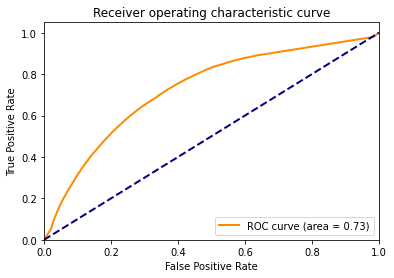

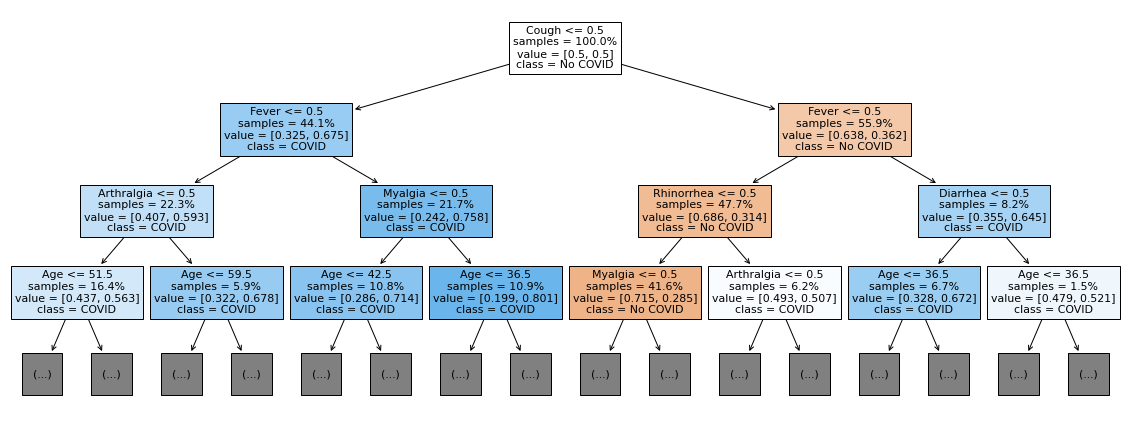

In [31]:
dt, acc = tree_classifier(X_train, y_train, X_test, y_test, max_depth=15, min_samples_leaf=1)
print("accuracy:", acc)
print("precision:", get_precision_score(dt, X_test, y_test))
print("recall:", get_sensibility(dt, X_test, y_test))
print("f1:", get_f1_score(dt, X_test, y_test))

y_score = dt.predict_proba(X_test)[:,1]
plot_roc(y_score, y_test)

fig = plt.figure(figsize=(20,7.5))
ax = fig.add_subplot(111)

tree.plot_tree(dt, max_depth=3, ax=ax, fontsize=11,feature_names=labels, class_names=["No COVID","COVID"],
               impurity=False, proportion=True, filled=True)

plt.show()

This doesn't seem to be such a good model, we won't use it.

## Covid, Symptoms, Comorbidities -> Hospitalized

Let's try to predict wheter a person that has covid will be hospitalized or not given his symptoms and comorbidities:

In [32]:
# X symptoms and comorbidities
# y is the hospitalized outcome
X = df_hosp.iloc[:,:-1].values
y = df_hosp.iloc[:,-1].values


In [33]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
y.sum()/len(y)

0.09771512372748815

In [35]:
labels = [labels_translation[x] for x in df_hosp.iloc[:,:-1].columns]

### Balancing the training set

In [36]:
X_train = np.concatenate((X_train[y_train==0][:len(y_train[y_train==1])], X_train[y_train==1]))
y_train = np.concatenate((y_train[y_train==0][:len(y_train[y_train==1])], y_train[y_train==1]))

#### Decisión tree

accuracy: 0.9221106423435735
precision: 0.5701028536076096
recall: 0.8810804350424286
f1: 0.6922715747957555


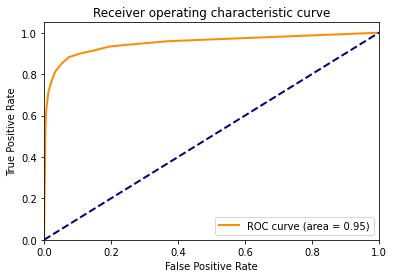

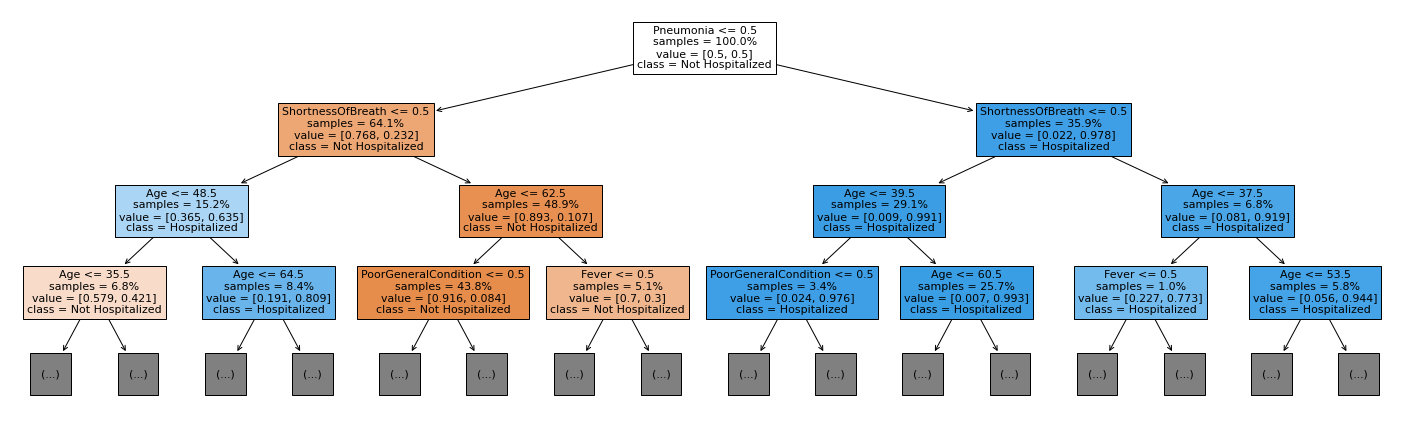

In [37]:
dt, acc = tree_classifier(X_train, y_train, X_test, y_test, max_depth=5, min_samples_leaf=1)
print("accuracy:", acc)
print("precision:", get_precision_score(dt, X_test, y_test))
print("recall:", get_sensibility(dt, X_test, y_test))
print("f1:", get_f1_score(dt, X_test, y_test))

y_score = dt.predict_proba(X_test)[:,1]
plot_roc(y_score, y_test)


fig = plt.figure(figsize=(25,7.5))
ax = fig.add_subplot(111)

tree.plot_tree(dt, max_depth=3, ax=ax, fontsize=11,feature_names=labels, class_names=["Not Hospitalized","Hospitalized"],
               impurity=False, proportion=True, filled=True)

plt.show()

## Covid, Comorbidities -> Death

In [38]:
# X commorbidites
# y is the hospitalized outcome
X = df_com.iloc[:,:-1].values
y = df_com.iloc[:,-1].values

In [39]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
y.sum()/len(y)

0.04613724469544094

In [41]:
labels = [labels_translation[x] for x in df_com.iloc[:,:-1].columns]

### Balancing the training set

In [42]:
X_train = np.concatenate((X_train[y_train==0][:len(y_train[y_train==1])], X_train[y_train==1]))
y_train = np.concatenate((y_train[y_train==0][:len(y_train[y_train==1])], y_train[y_train==1]))

#### Decisión tree

accuracy: 0.7695644423316893
precision: 0.14709230839291407
recall: 0.8301207915702904
f1: 0.24990328820116053


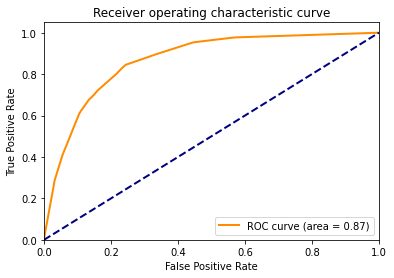

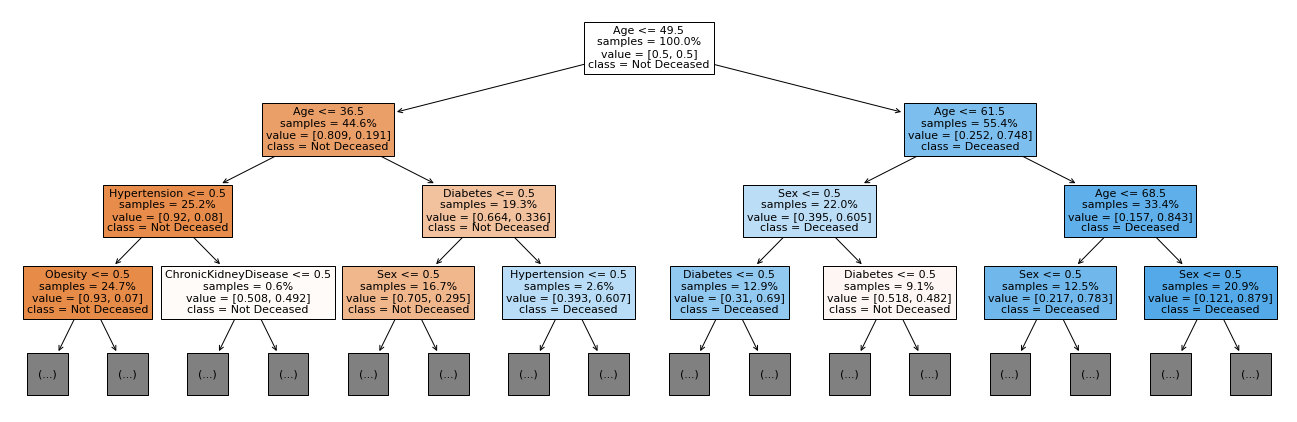

In [43]:
dt, acc = tree_classifier(X_train, y_train, X_test, y_test, max_depth=5, min_samples_leaf=1)
print("accuracy:", acc)
print("precision:", get_precision_score(dt, X_test, y_test))
print("recall:", get_sensibility(dt, X_test, y_test))
print("f1:", get_f1_score(dt, X_test, y_test))

y_score = dt.predict_proba(X_test)[:,1]
plot_roc(y_score, y_test)


fig = plt.figure(figsize=(23,7.5))
ax = fig.add_subplot(111)

tree.plot_tree(dt, max_depth=3, ax=ax, fontsize=11,feature_names=labels, class_names=["Not Deceased","Deceased"],
               impurity=False, proportion=True, filled=True)

plt.show()